# **Instalasi Library**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python-headless scikit-image numpy scikit-learn matplotlib seaborn

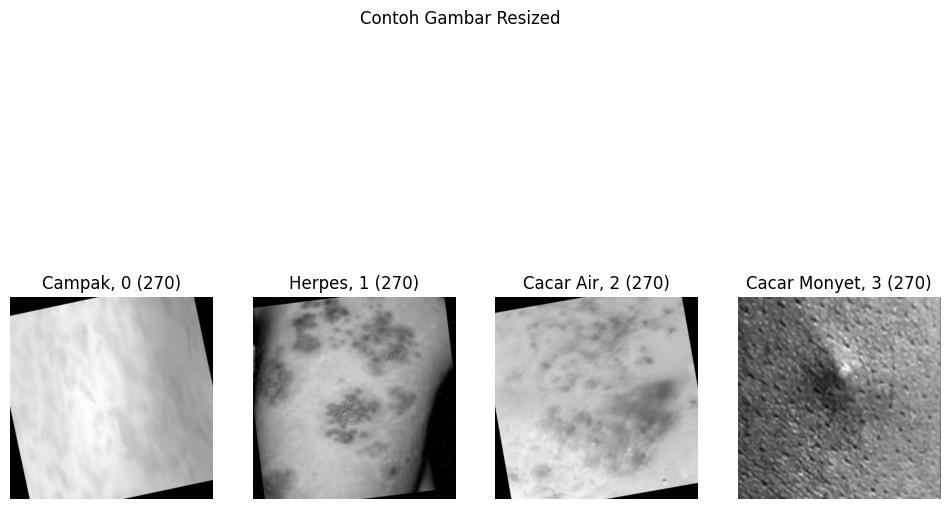

In [77]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import seaborn as sns

# 1. Load dan Visualisasi Data
DATA_DIR = '/content/drive/MyDrive/training_joki_31_dec'  # Ganti dengan lokasi dataset Anda
TARGET_SIZE = (500, 500)

def load_images(data_dir):
    images, paths, labels = [], [], []
    classes = os.listdir(data_dir)
    for label, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is None:
                print(f"Gagal membaca gambar: {img_path}")
                continue
            resized_img = cv2.resize(img, TARGET_SIZE) / 255.0  # Resize dan normalisasi
            images.append(resized_img)
            paths.append(img_path)
            labels.append(label)
    return np.array(images), np.array(labels), classes, np.array(paths)

images, labels, class_names, paths = load_images(DATA_DIR)

# Visualisasi contoh gambar resized
def visualize_images(images, labels, class_names, title):
    class_samples = defaultdict(list)
    for img, label in zip(images, labels):
        class_samples[label].append(img)

    plt.figure(figsize=(12, 8))
    for i, (label, imgs) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), i + 1)
        plt.imshow(imgs[0], cmap='gray')
        plt.title(f"{class_names[label]}, {label} ({len(imgs)})")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

visualize_images(images, labels, class_names, "Contoh Gambar Resized")


In [78]:
class_names

['Campak', 'Herpes', 'Cacar Air', 'Cacar Monyet']

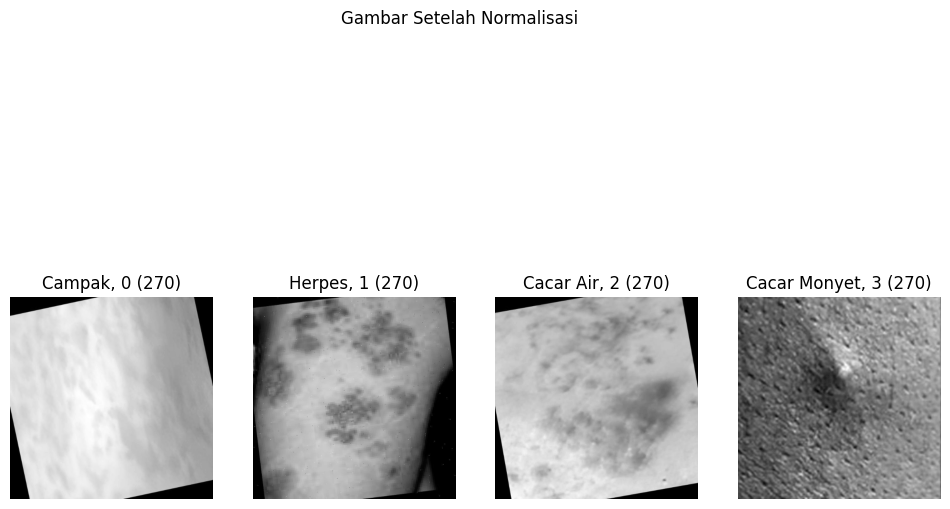

In [79]:
# 2. Preprocessing Data
# Visualisasi hasil normalisasi
normalized_images = images
visualize_images(normalized_images, labels, class_names, "Gambar Setelah Normalisasi")

# **Ekstraksi Fitur**

In [495]:
number_of_points=32
radius=4

In [496]:
def extract_lbp_features(images, P=number_of_points, R=radius):
  features = []
  for img in images:
    img = (img * 255).astype(np.uint8)  # Ensure image is in 0-255 range
    lbp = local_binary_pattern(img, P=P, R=R, method='uniform')
    # Flatten the LBP histogram into a 1D vector
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    features.append(hist.flatten())  # Append the flattened histogram
  return np.array(features)

lbp_features = extract_lbp_features(normalized_images)


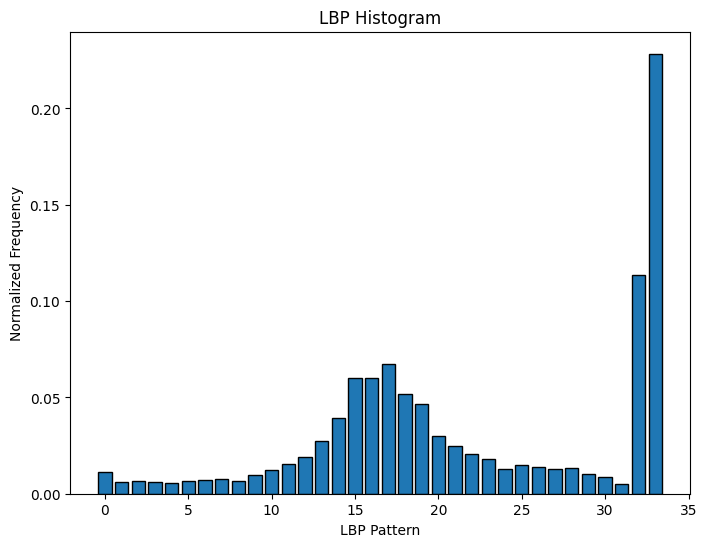

In [497]:
def display_lbp_histogram(image, P=number_of_points, R=radius):
    image = (image * 255).astype(np.uint8)  # Pastikan citra dalam skala 0-255
    lbp = local_binary_pattern(image, P=P, R=R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalisasi

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(hist)), hist, width=0.8, edgecolor='black')
    plt.title('LBP Histogram')
    plt.xlabel('LBP Pattern')
    plt.ylabel('Normalized Frequency')
    plt.show()

# Contoh penggunaan untuk salah satu gambar
display_lbp_histogram(images[0])


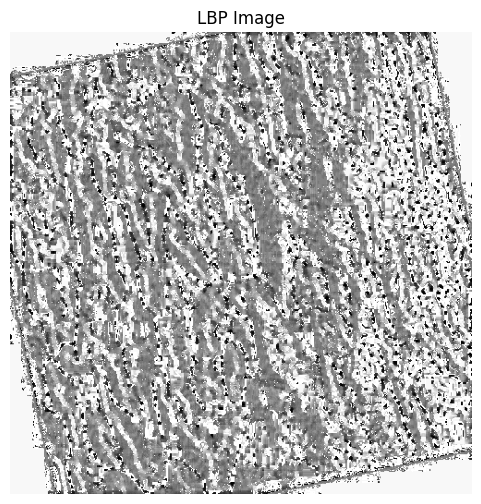

In [498]:
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

def display_lbp_image(image, P=number_of_points, R=radius):
    image = (image * 255).astype(np.uint8)  # Pastikan citra dalam skala 0-255
    lbp = local_binary_pattern(image, P=P, R=R, method='uniform')

    plt.figure(figsize=(6, 6))
    plt.imshow(lbp, cmap='gray')
    plt.title('LBP Image')
    plt.axis('off')
    plt.show()

# Contoh penggunaan untuk salah satu gambar
display_lbp_image(images[0])


In [499]:
# Cetak fitur LBP dari gambar pertama
print("LBP Features for the first image:")
print(lbp_features[0])


LBP Features for the first image:
[0.011404 0.006288 0.006752 0.006112 0.005556 0.006816 0.00704  0.00788
 0.006732 0.00946  0.012344 0.015512 0.0191   0.027444 0.039316 0.059824
 0.06006  0.067536 0.051688 0.046364 0.029988 0.024816 0.020508 0.017796
 0.012884 0.014724 0.013968 0.012936 0.013472 0.010004 0.008572 0.00528
 0.113424 0.2284  ]


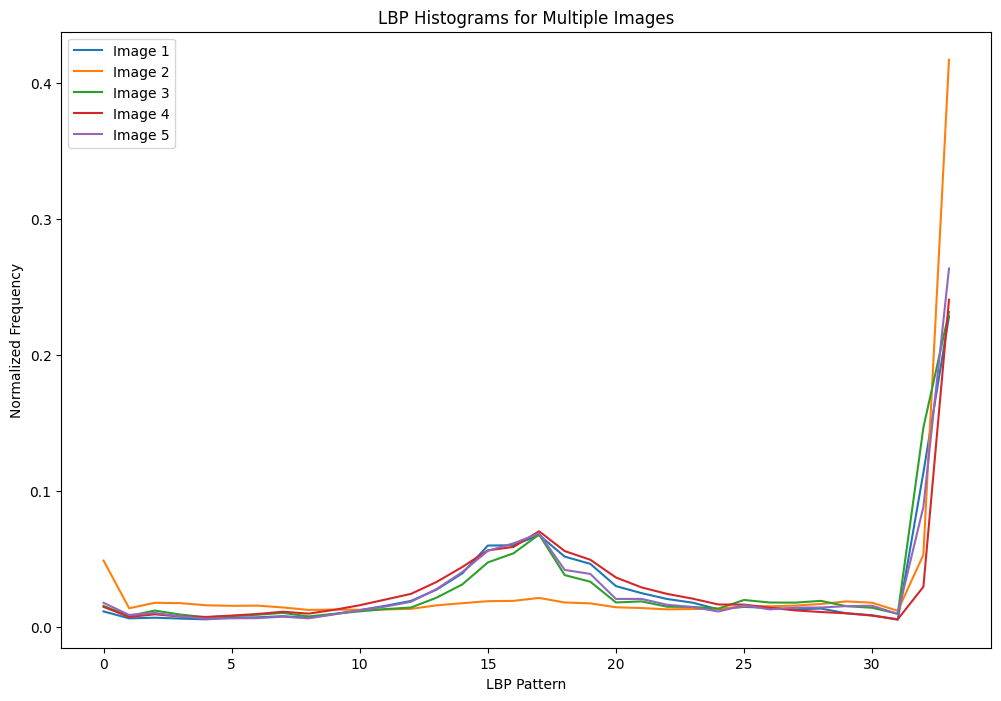

In [500]:
def display_multiple_histograms(lbp_features, P=number_of_points):
    plt.figure(figsize=(12, 8))
    for i, hist in enumerate(lbp_features[:5]):  # Tampilkan hanya 5 gambar pertama
        plt.plot(range(len(hist)), hist, label=f'Image {i+1}')

    plt.title('LBP Histograms for Multiple Images')
    plt.xlabel('LBP Pattern')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

# Tampilkan histogram dari beberapa gambar
display_multiple_histograms(lbp_features)


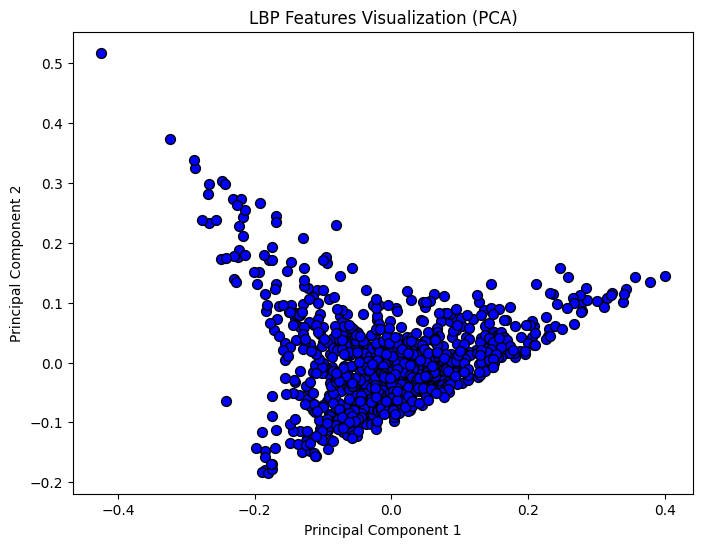

In [501]:
from sklearn.decomposition import PCA

def visualize_lbp_pca(features):
    pca = PCA(n_components=2)  # Proyeksi ke 2 dimensi
    reduced_features = pca.fit_transform(features)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', s=50, edgecolor='k')
    plt.title('LBP Features Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Visualisasikan fitur LBP
pca = visualize_lbp_pca(lbp_features)


In [502]:
import pickle
pickle.dump(pca, open('pca_model.pkl', 'wb'))

In [503]:
import pandas as pd
lbp_features = pd.DataFrame(lbp_features, columns=[f'LBP_{i}' for i in range(lbp_features.shape[1])])
lbp_features.head()

,LBP_0,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,...,LBP_24,LBP_25,LBP_26,LBP_27,LBP_28,LBP_29,LBP_30,LBP_31,LBP_32,LBP_33
0,0.011404,0.006288,0.006752,0.006112,0.005556,0.006816,0.007040,0.007880,0.006732,0.009460,...,0.012884,0.014724,0.013968,0.012936,0.013472,0.010004,0.008572,0.005280,0.113424,0.228400
1,0.048776,0.013716,0.017724,0.017484,0.015900,0.015496,0.015676,0.014288,0.012496,0.012768,...,0.013224,0.015264,0.015164,0.015676,0.016868,0.018772,0.017780,0.011836,0.053020,0.417112
2,0.015448,0.008100,0.012004,0.009076,0.007064,0.007988,0.008932,0.010304,0.007684,0.009632,...,0.013468,0.019792,0.017928,0.017844,0.019148,0.015220,0.014084,0.009632,0.146516,0.231640
3,0.014740,0.007328,0.009260,0.007604,0.007316,0.008328,0.009480,0.011172,0.009768,0.012536,...,0.016488,0.016404,0.014112,0.012136,0.010940,0.009996,0.008304,0.005612,0.029484,0.240552
4,0.017744,0.008784,0.010280,0.007724,0.006004,0.006320,0.006440,0.007528,0.006300,0.009196,...,0.011308,0.015956,0.012860,0.014200,0.014248,0.015300,0.015568,0.009556,0.088276,0.263600


In [505]:
lbp_features_min = lbp_features.min()
lbp_features_max = lbp_features.max()

In [506]:
lbp_minmax_df = pd.DataFrame({
    "Min": lbp_features_min,
    "Max": lbp_features_max
})

# Export ke file Excel
output_path = "lbp_minmax.xlsx"
lbp_minmax_df.to_excel(output_path, index_label="Feature")

In [507]:
def scale_numeric_columns(df, min_vals = lbp_features_min, max_vals = lbp_features_max):
    """
    Scale numeric columns in a DataFrame using Min-Max Scaling.

    Parameters:
    - df (pd.DataFrame): DataFrame yang akan di-scaling
    - min_vals (dict): Dictionary dengan format {column_name: min_value}
    - max_vals (dict): Dictionary dengan format {column_name: max_value}

    Returns:
    - pd.DataFrame: DataFrame dengan kolom numerik yang telah di-scale
    """
    scaled_df = df.copy()  # Salin DataFrame asli untuk di-scale

    for col in df.select_dtypes(include=[np.number]).columns:
        if col in min_vals and col in max_vals:  # Pastikan kolom ada di min/max
            min_val = min_vals[col]
            max_val = max_vals[col]
            scaled_df[col] = (df[col] - min_val) / (max_val - min_val)  # Scaling
        else:
            print(f"Skipping column '{col}' as it lacks min or max values.")

    return scaled_df

In [508]:
scaled_lbp_features = scale_numeric_columns(lbp_features)
scaled_lbp_features

,LBP_0,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,...,LBP_24,LBP_25,LBP_26,LBP_27,LBP_28,LBP_29,LBP_30,LBP_31,LBP_32,LBP_33
0,0.138040,0.196384,0.227302,0.248335,0.169467,0.182325,0.294425,0.288272,0.268437,0.347935,...,0.545455,0.326125,0.462043,0.326308,0.234316,0.322304,0.281353,0.103179,0.140251,0.274379
1,0.636572,0.454659,0.662698,0.746583,0.511576,0.429450,0.683926,0.569522,0.527005,0.477315,...,0.561129,0.339896,0.507622,0.414343,0.321491,0.706057,0.659225,0.281002,0.055317,0.577149
2,0.191985,0.259388,0.435714,0.378198,0.219341,0.215693,0.379758,0.394663,0.311143,0.354662,...,0.572377,0.455371,0.612957,0.483999,0.380018,0.550595,0.507551,0.221222,0.186783,0.279577
3,0.182541,0.232545,0.326825,0.313705,0.227676,0.225373,0.404474,0.432760,0.404629,0.468242,...,0.711599,0.368969,0.467530,0.300604,0.169319,0.321954,0.270355,0.112184,0.022222,0.293876
4,0.222614,0.283171,0.367302,0.318962,0.184284,0.168204,0.267364,0.272823,0.249058,0.337610,...,0.472801,0.357544,0.419817,0.366919,0.254236,0.554097,0.568450,0.219160,0.104890,0.330854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.178486,0.120167,0.165556,0.297056,0.285091,0.273431,0.484214,0.521945,0.554638,0.573686,...,0.530149,0.258288,0.386280,0.269888,0.148475,0.262955,0.224557,0.073777,0.006749,0.174521
1076,0.376607,0.301530,0.459365,0.581668,0.421881,0.349505,0.532564,0.495084,0.552306,0.520964,...,0.482759,0.240743,0.391159,0.311657,0.214601,0.485819,0.488510,0.247694,0.027318,0.409605
1077,0.234673,0.298887,0.376667,0.400280,0.261146,0.217857,0.329605,0.332338,0.376099,0.424593,...,0.371934,0.186984,0.280030,0.221694,0.178252,0.465861,0.489494,0.197244,0.014489,0.407339
1078,0.378208,0.330320,0.440635,0.512794,0.351766,0.288919,0.447411,0.398350,0.441773,0.439612,...,0.398857,0.220953,0.317988,0.276828,0.203614,0.504202,0.547111,0.243029,0.018983,0.421554


In [509]:
scaled_lbp_features.describe()

,LBP_0,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,...,LBP_24,LBP_25,LBP_26,LBP_27,LBP_28,LBP_29,LBP_30,LBP_31,LBP_32,LBP_33
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.282019,0.253017,0.327377,0.359663,0.263079,0.251507,0.394431,0.387760,0.381458,0.436116,...,0.588237,0.373996,0.480975,0.384834,0.256509,0.428569,0.392109,0.192640,0.110430,0.346489
std,0.174310,0.137372,0.168063,0.178682,0.134154,0.125708,0.187143,0.152678,0.166267,0.142479,...,0.160451,0.130712,0.152675,0.146386,0.128345,0.175165,0.175461,0.095715,0.109441,0.149889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.154954,0.159353,0.217817,0.230591,0.165068,0.162909,0.252526,0.263825,0.255921,0.329553,...,0.483865,0.297332,0.382812,0.287045,0.176661,0.300814,0.263296,0.129950,0.042010,0.244174
50%,0.253588,0.234840,0.285635,0.334648,0.255325,0.244164,0.389771,0.373596,0.374933,0.428426,...,0.607874,0.368714,0.485290,0.369040,0.233648,0.403099,0.355548,0.175491,0.075722,0.337644
75%,0.362988,0.310292,0.404881,0.463679,0.348095,0.329376,0.520341,0.489115,0.488426,0.534887,...,0.702194,0.436219,0.576524,0.457653,0.312429,0.547138,0.486991,0.236302,0.141171,0.418119
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [510]:
# 4. Pembagian Data
scaled_lbp_features['paths'] = paths
X_train, X_test, y_train, y_test = train_test_split(scaled_lbp_features, labels, test_size=0.3, random_state=42, stratify=labels)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_path_train = X_train['paths'].copy()
X_path_test = X_test['paths'].copy()
X_train = X_train.drop(columns=['paths'])
X_test = X_test.drop(columns=['paths'])

In [511]:
X_train

,LBP_0,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8,LBP_9,...,LBP_24,LBP_25,LBP_26,LBP_27,LBP_28,LBP_29,LBP_30,LBP_31,LBP_32,LBP_33
0,0.094072,0.168846,0.268254,0.227305,0.166160,0.196447,0.287209,0.301615,0.266284,0.440081,...,0.807118,0.610527,0.673171,0.540033,0.312660,0.498424,0.332896,0.153412,0.107894,0.325765
1,0.095939,0.100278,0.365079,0.165265,0.065882,0.066166,0.096699,0.236131,0.127400,0.299124,...,0.869814,0.753443,0.933232,0.870454,0.669679,0.795518,0.596684,0.286970,0.278540,0.226645
2,0.073849,0.089430,0.118730,0.132492,0.088901,0.090309,0.143785,0.185920,0.142832,0.210263,...,0.426517,0.603081,0.370579,0.349955,0.206797,0.360994,0.338969,0.195725,0.464462,0.115883
3,0.653487,0.372601,0.566508,0.680862,0.456145,0.376950,0.702688,0.664853,0.637179,0.572278,...,0.611838,0.374171,0.555640,0.357666,0.252182,0.569503,0.590118,0.261799,0.049973,0.484543
4,0.104637,0.127955,0.229365,0.163162,0.100542,0.100558,0.185098,0.282303,0.247622,0.368116,...,0.707911,0.492706,0.610518,0.498651,0.356505,0.467787,0.358175,0.168927,0.190973,0.259586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.472600,0.401947,0.566190,0.606905,0.374520,0.343355,0.521198,0.506320,0.424367,0.416927,...,0.595980,0.410895,0.598628,0.514073,0.455591,0.719013,0.676789,0.282196,0.106342,0.570019
752,0.266475,0.170376,0.221111,0.377322,0.307713,0.360779,0.618438,0.685218,0.685448,0.716521,...,0.877927,0.452004,0.580793,0.377972,0.200945,0.239146,0.181714,0.083758,0.035580,0.218558
753,0.537218,0.382754,0.453333,0.682790,0.657759,0.572828,0.740935,0.536166,0.519648,0.507196,...,0.539554,0.359176,0.584909,0.584501,0.404764,0.607493,0.467663,0.250515,0.055676,0.486314
754,0.322928,0.250348,0.315873,0.419909,0.359174,0.324564,0.537074,0.481917,0.516598,0.575563,...,0.660520,0.410487,0.477744,0.382085,0.228052,0.404237,0.349803,0.188456,0.086527,0.358912


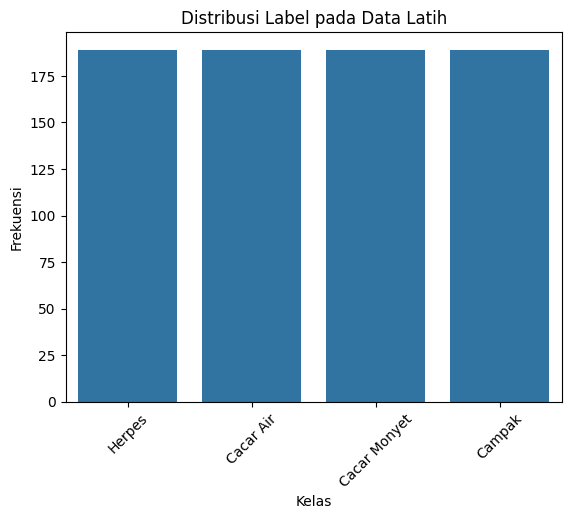

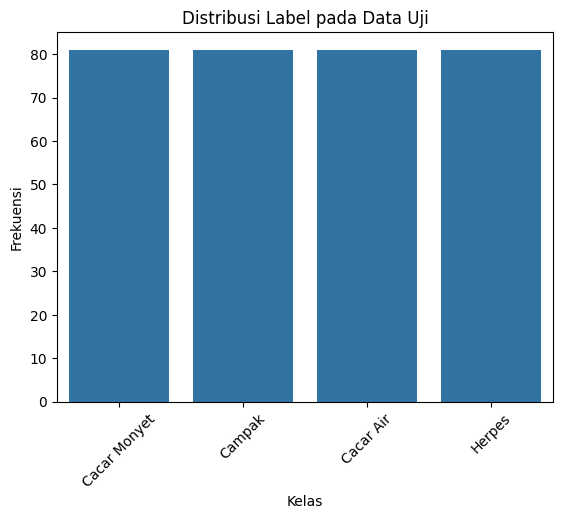

In [512]:
# Visualisasi distribusi label
def visualize_label_distribution(labels, class_names, title):
    sns.countplot(x=[class_names[label] for label in labels])
    plt.title(title)
    plt.xlabel("Kelas")
    plt.ylabel("Frekuensi")
    plt.xticks(rotation=45)
    plt.show()

visualize_label_distribution(y_train, class_names, "Distribusi Label pada Data Latih")
visualize_label_distribution(y_test, class_names, "Distribusi Label pada Data Uji")

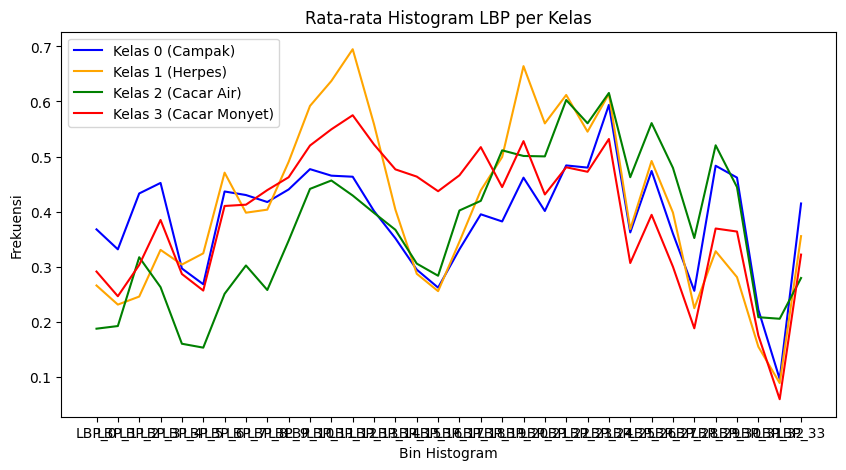

In [513]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data histogram LBP berdasarkan kelas
lbp_kelas_0 = X_train[y_train == 0]
lbp_kelas_1 = X_train[y_train == 1]
lbp_kelas_2 = X_train[y_train == 2]
lbp_kelas_3 = X_train[y_train == 3]

# Plot rata-rata histogram LBP untuk setiap kelas
plt.figure(figsize=(10, 5))
plt.plot(np.mean(lbp_kelas_0, axis=0), label="Kelas 0 (Campak)", color="blue")
plt.plot(np.mean(lbp_kelas_1, axis=0), label="Kelas 1 (Herpes)", color="orange")
plt.plot(np.mean(lbp_kelas_2, axis=0), label="Kelas 2 (Cacar Air)", color="green")
plt.plot(np.mean(lbp_kelas_3, axis=0), label="Kelas 3 (Cacar Monyet)", color="red")
plt.title("Rata-rata Histogram LBP per Kelas")
plt.xlabel("Bin Histogram")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()


# **Pembuatan Dan Pelatihan Model LVQ**

In [514]:
#python version
!python --version


Python 3.10.12


In [515]:
# Menghitung jumlah seluruh data
total_data = len(labels)  # Atau bisa menggunakan len(y) jika variabel y adalah target asli

print("Jumlah seluruh data:", total_data)


Jumlah seluruh data: 1080


In [516]:
print(lbp_features.shape, X_train.shape, X_test.shape)

(1080, 34) (756, 34) (324, 34)


In [517]:
from collections import Counter
print("Distribusi label:", Counter(labels))


Distribusi label: Counter({0: 270, 1: 270, 2: 270, 3: 270})


In [518]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [519]:
n_input = X_train.shape[1]
n_output = len(np.unique(y_train))

print('Input Neuron:', n_input)
print('Output Neuron:', n_output)

Input Neuron: 34
Output Neuron: 4


In [531]:
class LVQ:
    def __init__(self, learning_rate=0.01, max_epochs=1000):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.prototypes = None
        self.labels = None

    def fit(self, X, y, n_prototypes_per_class=50):
        """
        X: array data input (n_samples, n_features)
        y: array label (n_samples,)
        n_prototypes_per_class: jumlah prototype per kelas
        """
        np.random.seed(42)

        # Identifikasi jumlah kelas unik
        classes = np.unique(y)
        self.prototypes = []
        self.labels = []

        # Inisialisasi vektor prototipe untuk setiap kelas
        for cls in classes:
            class_samples = X[y == cls]
            for _ in range(n_prototypes_per_class):
                idx = np.random.choice(len(class_samples))
                self.prototypes.append(class_samples[idx])
                self.labels.append(cls)

        self.prototypes = np.array(self.prototypes)

        # Proses pelatihan
        for epoch in range(self.max_epochs):
            for xi, yi in zip(X, y):
                # Hitung jarak antara data dan prototipe
                distances = np.linalg.norm(self.prototypes - xi, axis=1)
                nearest_idx = np.argmin(distances)
                nearest_label = self.labels[nearest_idx]

                # Update prototipe jika label cocok atau tidak
  # Update prototipe
                if yi == nearest_label:
                    self.prototypes[nearest_idx] += self.learning_rate * (xi - self.prototypes[nearest_idx])
                else:
                    self.prototypes[nearest_idx] -= self.learning_rate * (xi - self.prototypes[nearest_idx])



            # Update learning rate (opsional: bisa dikurangi setiap epoch)
            self.learning_rate *= 0.99

    def predict(self, X):
        """
        X: array data input (n_samples, n_features)
        """
        y_pred = []
        for xi in X:
            # Reshape xi to (1, n_features) for broadcasting
            xi = xi.reshape(1, -1)  # This will reshape xi to (1, 10)
            # print(f"Data input: {xi}")
            distances = np.linalg.norm(self.prototypes - xi, axis=1)
            # print(f"Distances: {distances}")
            nearest_idx = np.argmin(distances)
            y_pred.append(self.labels[nearest_idx])
        return np.array(y_pred)

Accuracy: 0.9074074074074074
Precision: 0.9149496183798356
Recall: 0.9074074074074074
F1 Score: 0.9077723556890223
              precision    recall  f1-score   support

      Campak       0.89      0.89      0.89        81
      Herpes       0.98      0.98      0.98        81
   Cacar Air       0.81      0.95      0.88        81
Cacar Monyet       0.99      0.81      0.89        81

    accuracy                           0.91       324
   macro avg       0.91      0.91      0.91       324
weighted avg       0.91      0.91      0.91       324



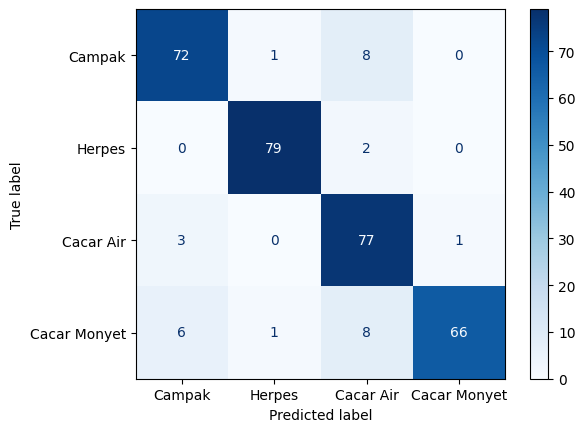

In [532]:
lvq = LVQ(learning_rate=0.01, max_epochs=500)
lvq.fit(X_train, y_train,  n_prototypes_per_class=200)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

# Prediksi pada data uji
y_pred = lvq.predict(X_test)

# Evaluasi performa model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot(cmap='Blues')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print(classification_report(y_test, y_pred, target_names=class_names))

In [533]:
X_path_test

,paths
0,/content/drive/MyDrive/training_joki_31_dec/Ca...
1,/content/drive/MyDrive/training_joki_31_dec/Ca...
2,/content/drive/MyDrive/training_joki_31_dec/Ca...
3,/content/drive/MyDrive/training_joki_31_dec/Ca...
4,/content/drive/MyDrive/training_joki_31_dec/Ca...
...,...
319,/content/drive/MyDrive/training_joki_31_dec/He...
320,/content/drive/MyDrive/training_joki_31_dec/Ca...
321,/content/drive/MyDrive/training_joki_31_dec/Ca...
322,/content/drive/MyDrive/training_joki_31_dec/Ca...


Prediksi: 0, Label Sebenarnya: 0, Path Gambar: /content/drive/MyDrive/training_joki_31_dec/Campak/measles106_png.rf.333e720eb4a3191ed91a1dd139f18a62.jpg


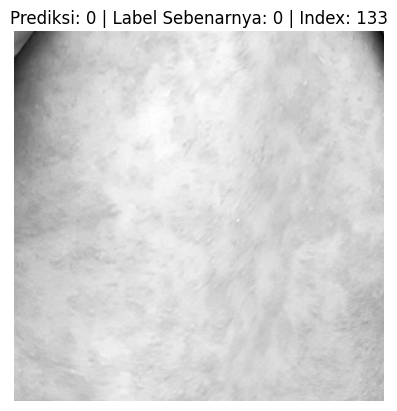

Prediksi: 1, Label Sebenarnya: 1, Path Gambar: /content/drive/MyDrive/training_joki_31_dec/Herpes/herpes303_jpg.rf.234c7510f49cb43920440f39635481e3.jpg


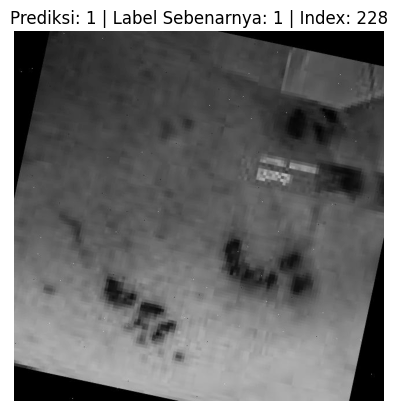

Prediksi: 2, Label Sebenarnya: 2, Path Gambar: /content/drive/MyDrive/training_joki_31_dec/Cacar Air/chickenpox61_png.rf.d74debace67bd9e02a054c1860af4a7d.jpg


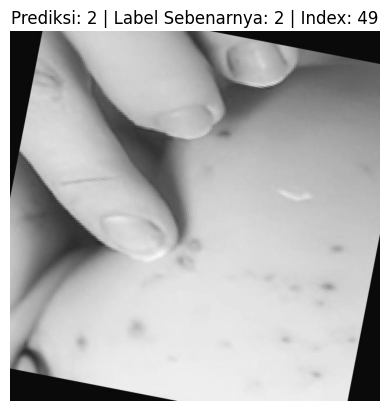

Prediksi: 2, Label Sebenarnya: 2, Path Gambar: /content/drive/MyDrive/training_joki_31_dec/Cacar Air/chickenpox81_png.rf.6af47ccd88a4fd344a156a1a1242dff3.jpg


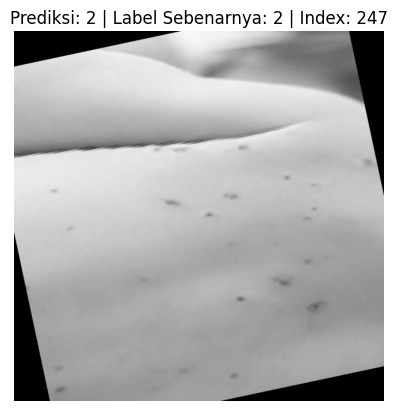

Prediksi: 1, Label Sebenarnya: 1, Path Gambar: /content/drive/MyDrive/training_joki_31_dec/Herpes/herpes286_jpg.rf.8de441af2ee56f0086a77a97e73a7308.jpg


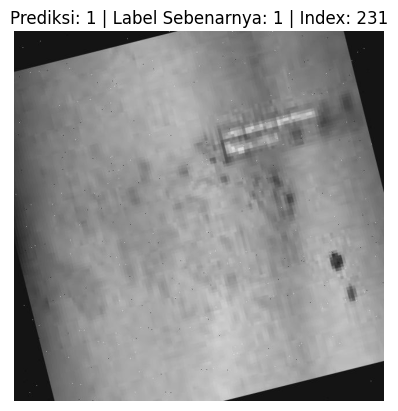

In [534]:
import random
# Pilih beberapa indeks acak dari data uji untuk analisis
sample_indices = random.sample(range(len(X_test)), 5)
for idx in sample_indices:
    prediction = lvq.predict([X_test[idx]])[0]
    actual_label = y_test[idx]

    print(f"Prediksi: {prediction}, Label Sebenarnya: {actual_label}, Path Gambar: {X_path_test[idx]}")
    img = cv2.imread(X_path_test[idx], cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, TARGET_SIZE) / 255.0  # Resize dan normalisasi
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediksi: {prediction} | Label Sebenarnya: {actual_label} | Index: {idx}')
    plt.axis('off')
    plt.show()


In [535]:
import pickle
filename = 'lvq.pkl'
with open(filename, 'wb') as f:
    pickle.dump(lvq, f)

In [536]:
paths = pd.DataFrame(paths, columns=['paths'])
paths.head()

,paths
0,/content/drive/MyDrive/training_joki_31_dec/Ca...
1,/content/drive/MyDrive/training_joki_31_dec/Ca...
2,/content/drive/MyDrive/training_joki_31_dec/Ca...
3,/content/drive/MyDrive/training_joki_31_dec/Ca...
4,/content/drive/MyDrive/training_joki_31_dec/Ca...


In [537]:
def find_index_by_value(df, column_name, value):
    """
    Mencari indeks baris berdasarkan nilai di suatu kolom.

    Parameters:
    - df (pd.DataFrame): DataFrame yang akan dicari.
    - column_name (str): Nama kolom tempat nilai akan dicari.
    - value: Nilai yang ingin dicari.

    Returns:
    - list: Daftar indeks baris yang cocok dengan nilai tersebut.
            Jika nilai tidak ditemukan, mengembalikan list kosong.
    """
    try:
        # Cari indeks baris yang sesuai
        indices = df.index[df[column_name] == value].tolist()
        if indices:
            return indices
        else:
            print(f"Nilai '{value}' tidak ditemukan di kolom '{column_name}'.")
            return []
    except KeyError:
        print(f"Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        return []
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
        return []

In [538]:
def save_numpy_to_excel(array, path, sheet_name='Sheet1', header=None, index=False):
    """
    Menyimpan array NumPy ke file Excel.

    Parameters:
    - array (np.ndarray): Array NumPy yang akan disimpan.
    - path (str): Path lengkap untuk menyimpan file Excel, termasuk nama file dan ekstensi (.xlsx).
    - sheet_name (str): Nama sheet dalam file Excel. Default 'Sheet1'.
    - header (list or None): Daftar header kolom. Jika None, tidak ada header.
    - index (bool): Jika True, tambahkan indeks ke file Excel. Default False.

    Returns:
    - None
    """
    try:
        # Konversi NumPy array ke DataFrame
        df = pd.DataFrame(array)

        # Tambahkan header jika diberikan
        if header:
            df.columns = header

        # Simpan DataFrame ke file Excel
        df.to_excel(path, index=index, sheet_name=sheet_name)
        print(f"Array berhasil disimpan ke file Excel: {path}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

In [539]:
from skimage.feature import local_binary_pattern
from PIL import Image
import numpy as np

# Definisikan label_map untuk memetakan indeks prediksi ke label kelas
label_map = {
    0: "Campak",
    1: "Herpes",
    2: "Cacar Air",
    3: "Cacar Monyet"
}

def predict_single_image(image_path, lvq, target_size=(500, 500), P=number_of_points, R=radius):
    """
    image_path: path ke gambar yang akan diuji
    lvq: model LVQ yang telah dilatih
    target_size: ukuran gambar yang di-resize
    P, R: Parameter untuk LBP
    """
    # Load dan preprocess gambar
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_array = cv2.resize(img, (500,500)) / 255.0

    # Ekstraksi fitur LBP
    img_array = (img_array * 255).astype(np.uint8)  # Konversi ke uint8
    lbp = local_binary_pattern(img_array, P=P, R=R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalisasi histogram
    img_array = hist  # Gunakan histogram sebagai input model

    # Debugging: Periksa dimensi fitur
    # print(f"LBP histogram for single image: {img_array}")
    img_array = img_array.reshape(1,-1)
    img_df = pd.DataFrame(img_array, columns=[f'LBP_{i}' for i in range(lbp_features.shape[1])])
    img_df = scale_numeric_columns(img_df)
    img_array = np.array(img_df)

    # Prediksi dengan model
    prediction = lvq.predict([img_array])  # Pass the LBP features for prediction

    # Debugging: Periksa hasil prediksi
    # print(f"Prediction index: {prediction[0]})")

    # # Konversi indeks prediksi ke label
    predicted_label = label_map.get(prediction[0], "Unknown")
    print(f"Predicted label: {predicted_label}")
    # predicted_label = "dimatikan"
    return predicted_label

# Pastikan lvq sudah dilatih dengan data
test_image_paths = [
    '/content/drive/MyDrive/training_joki_31_dec/Herpes/herpes172_jpg.rf.571503def4c319e7a8a6b1430b05baa5.jpg',
    '/content/drive/MyDrive/training_joki_31_dec/Herpes/herpes165_jpg.rf.d7ee3770e3a1d0a51183b542cfdef689.jpg',
    '/content/drive/MyDrive/training_joki_31_dec/Herpes/herpes180_jpg.rf.ac57b22e8f74cbc3143df4dad6c0b282.jpg',
    '/content/drive/MyDrive/training_joki_31_dec/Campak/measles126_jpg.rf.492d94e0ebc2569fa65a48b1a3722502.jpg',
    '/content/drive/MyDrive/training_joki_31_dec/Cacar Air/chickenpox114_png.rf.d77573e2b1e21e56597edc9e5cdf06ee.jpg'
]

# Loop through each image path and make predictions
for image_path in test_image_paths:
    predicted_class, image_processed_baru = predict_single_image(image_path, lvq)
    print(f"Predicted class for {image_path}: {predicted_class}")

Predicted label: Herpes
Predicted class for /content/drive/MyDrive/training_joki_31_dec/Herpes/herpes172_jpg.rf.571503def4c319e7a8a6b1430b05baa5.jpg: Herpes
Predicted label: Herpes
Predicted class for /content/drive/MyDrive/training_joki_31_dec/Herpes/herpes165_jpg.rf.d7ee3770e3a1d0a51183b542cfdef689.jpg: Herpes
Predicted label: Herpes
Predicted class for /content/drive/MyDrive/training_joki_31_dec/Herpes/herpes180_jpg.rf.ac57b22e8f74cbc3143df4dad6c0b282.jpg: Herpes
Predicted label: Campak
Predicted class for /content/drive/MyDrive/training_joki_31_dec/Campak/measles126_jpg.rf.492d94e0ebc2569fa65a48b1a3722502.jpg: Campak
Predicted label: Cacar Air
Predicted class for /content/drive/MyDrive/training_joki_31_dec/Cacar Air/chickenpox114_png.rf.d77573e2b1e21e56597edc9e5cdf06ee.jpg: Cacar Air


In [589]:
import pickle
filename = 'model_lvq_baru.pkl'
pickle.dump(lvq, open(filename, 'wb'))

In [562]:
predictions = {}
for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    sampled_images = random.sample(images, min(25, len(images)))

    # Prediksi setiap gambar
    predictions[folder] = []
    print(f"\nPredictions for {folder}:\n=============")
    for image_path in sampled_images:
        # Ini fungsi prediksi yang kamu minta ya bro :D
        predicted_label = predict_single_image(image_path, lvq)
        predictions[folder].append((image_path, predicted_label))


Predictions for Campak:
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak
Predicted label: Campak

Predictions for Herpes:
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted label: Herpes
Predicted labe

In [568]:
jumlah_prediksi_benar = 0
for folder, image_labels in predictions.items():
    for _, label in image_labels:
        if label[0] == folder:
            jumlah_prediksi_benar += 1

total_data_uji_subset = len(predictions[folder]*4)
akurasi_subset = (jumlah_prediksi_benar / total_data_uji_subset) * 100

print(f"Jumlah Data Uji (Subset): {total_data_uji_subset}")
print(f"Jumlah Prediksi Benar (Subset): {jumlah_prediksi_benar}")
print(f"Akurasi Model LVQ pada Subset: {akurasi_subset:.2f}%")


Jumlah Data Uji (Subset): 100
Jumlah Prediksi Benar (Subset): 98
Akurasi Model LVQ pada Subset: 98.00%


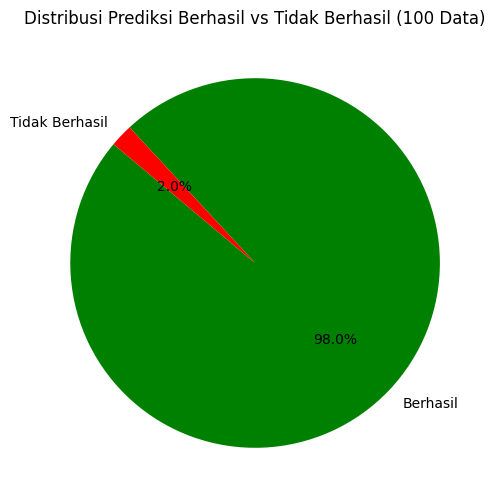

In [569]:
# Data untuk visualisasi
counts_subset = [jumlah_prediksi_benar, total_data_uji_subset - jumlah_prediksi_benar]
labels_subset = ['Berhasil', 'Tidak Berhasil']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(counts_subset, labels=labels_subset, autopct='%1.1f%%', startangle=140, colors=['green', 'red'])
plt.title("Distribusi Prediksi Berhasil vs Tidak Berhasil (100 Data)")
plt.show()


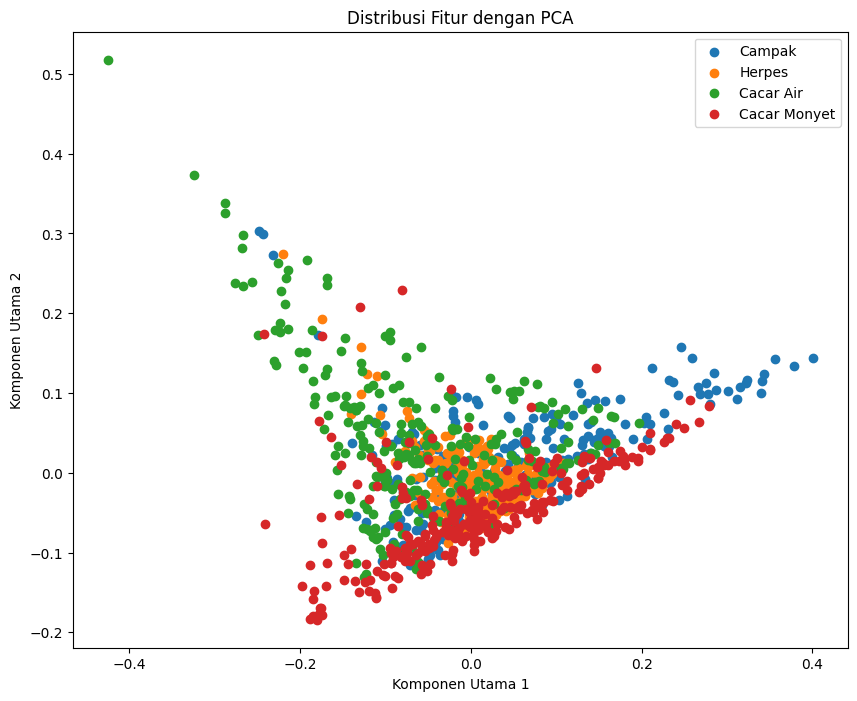

In [549]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduksi ke 2 dimensi
X_pca = pca.fit_transform(lbp_features)

# Visualisasi PCA
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=class_name)
plt.title("Distribusi Fitur dengan PCA")
plt.xlabel("Komponen Utama 1")
plt.ylabel("Komponen Utama 2")
plt.legend()
plt.show()

Accuracy: 0.8395061728395061
Precision: 0.8485109071593029
Recall: 0.8395061728395061
F1 Score: 0.8405248585933758
              precision    recall  f1-score   support

      Campak       0.66      0.80      0.73        81
      Herpes       0.99      1.00      0.99        81
   Cacar Air       0.82      0.68      0.74        81
Cacar Monyet       0.92      0.88      0.90        81

    accuracy                           0.84       324
   macro avg       0.85      0.84      0.84       324
weighted avg       0.85      0.84      0.84       324



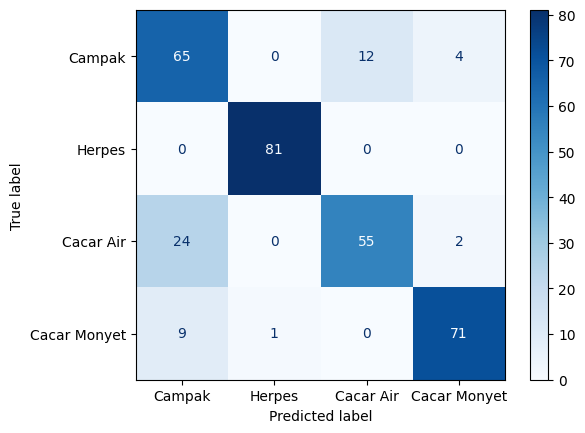

In [570]:
#melatih menggunakan svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Memisahkan data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(lbp_features, labels, test_size=0.3, random_state=42, stratify=labels)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot(cmap='Blues')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print(classification_report(y_test, y_pred, target_names=class_names))


In [572]:
# Menghitung jumlah data latih
num_train_data = len(X_test)

print("Jumlah data latih:", num_train_data)


Jumlah data latih: 324
